# Titanic - Exploratory Data Analysis - 04

In [1]:
# Import libraries
import scipy
import pandas as pd
import numpy as np

from scipy.stats import shapiro

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split

from sklearn import ensemble
from sklearn import gaussian_process
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import discriminant_analysis

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

filepath_train = r'Titanic\Data\train.csv'
filepath_test = r'Titanic\Data\test.csv'
np.random.seed(17)
%matplotlib inline

In [2]:
# Import data
df = pd.read_csv(filepath_train)

### Inspect surface-level details of data

#### Data Dictionary

  * survival
    * Survival
      * 0 = No
      * 1 = Yes
  * pclass
    * Ticket class - proxy for socio-economic status
      * 1 = 1st
      * 2 = 2nd
      * 3 = 3rd
  * sex
    * Sex
  * Age
    * Age in years - fractional if less than 1
    * If the age is estimated, it is in the form of xx.5
  * sibsp
    * \# of siblings / spouses aboard the Titanic
      * Sibling = brother, sister, stepbrother, stepsister
      * Spouse = husband, wife (mistresses and fiances were ignored)
  * parch
    * \# of parents / children aboard the Titanic
      * Parent = mother, father
      * Child = daughter, son, stepdaughter, stepson
      * Some children travelled only with a nanny, therefore parch=0 for them
  * ticket
    * Ticket number
  * fare
    * Passenger fare
  * cabin
    * Cabin number
  * embarked
    * Port of Embarkation
      * C = Cherbourg
      * Q = Queenstown
      * S = Southampton

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We should, first, inspect our dataset for missing values.

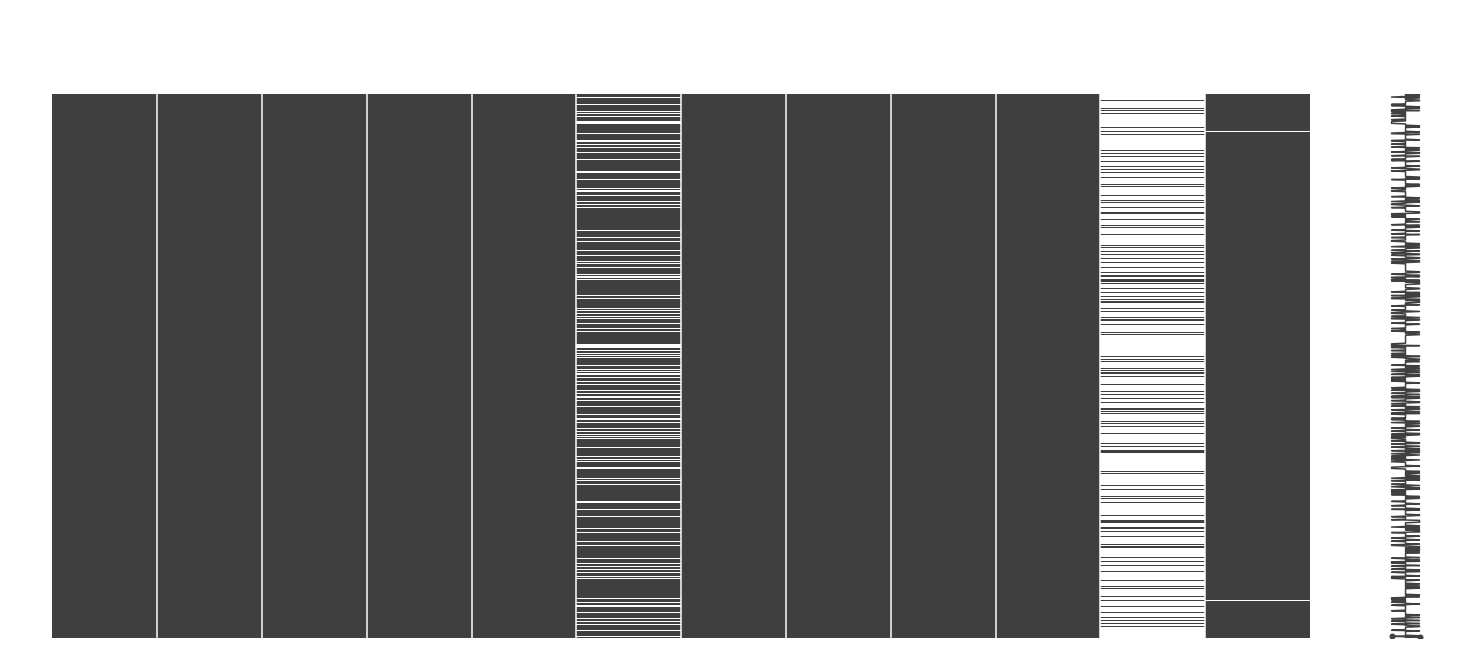

In [6]:
msno.matrix(df)

In [7]:
round(df.isnull().sum()/len(df)*100, 2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

Looks like we have a couple fields with missing values - "Age", "Cabin", and "Embarked".

Out of each of these, only two are within acceptable ranges of missing values - "Age" and "Embarked". Unfortunately, that means we should probably drop the field "Cabin" since a ton of records are missing their values.

After dropping "Cabin", we'll check to see how many records we would potentially drop if we removed all records with missing values for "Age" and "Embarked".

In [8]:
df = df.drop("Cabin", axis=1)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [9]:
print("Total # of values: %d" % len(df))
print("Total # of missing values: %d" % df.isnull().sum().sum())

Total # of values: 891
Total # of missing values: 179


Until we figure out something more "robust" we'll just impute values for our missing data.

In [10]:
imp_missing = make_column_transformer(
    (SimpleImputer(strategy='median'), ['Age']),
    (SimpleImputer(strategy='most_frequent'), ['Embarked'])
)
imp_missing.fit(df)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('simpleimputer-1',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               missing_values=nan,
                                               strategy='median', verbose=0),
                                 ['Age']),
                                ('simpleimputer-2',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               missing_values=nan,
                                               strategy='most_frequent',
                                               verbose=0),
                                 ['Embarked'])],
                  verbose=False)

In [11]:
df[['Age', 'Embarked']] = imp_missing.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [12]:
print("Baseline prediction accuracy:\t%.3f%%" % float(df[df['Sex']=='female']['Survived'].sum()/len(df[df['Sex']=='female'])*100))
print('Female survival rate:\t%.3f%%' % float(df[df['Sex']=='female']['Survived'].sum()/len(df[df['Sex']=='female'])*100))
print('Percentage female:\t%.3f%%' % float(len(df[df['Sex']=='female'])/len(df)*100))

Baseline prediction accuracy:	74.204%
Female survival rate:	74.204%
Percentage female:	35.241%


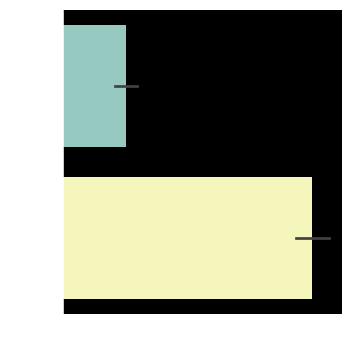

In [13]:
sns.catplot(x='Survived', y='Sex', data=df, kind='bar', orient='h')

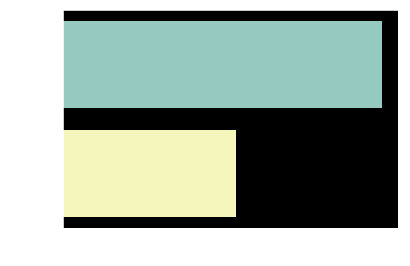

In [14]:
sns.countplot(y='Sex', data=df, orient='h')

We're going to set our baseline prediction acccuracy at 74.2% which is as accurate as saying all females survived. Anything above this will be considered "good".

Let's examine the discrete variables.

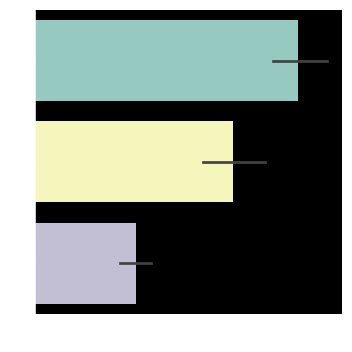

In [15]:
sns.catplot(x='Survived', y='Pclass', kind='bar', data=df, orient='h')

Looks like there's some correlation between passenger class and survival rate...

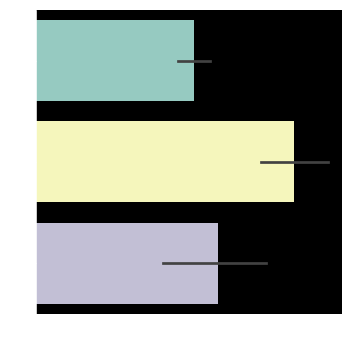

In [16]:
sns.catplot(x='Survived', y='Embarked', kind='bar', data=df, orient='h')

... passengers embarking from Cherbourg had a higher survival rate than Queenstown and Queenstown is higher than Southampton.

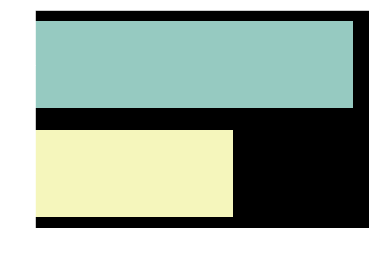

In [17]:
sns.countplot(y='Survived', data=df, orient='h')

One hypothesis we could make from the above visuals is that women in 1st class department from Cherbourg would have a relatively higher survival rate than any other passenger (on average).

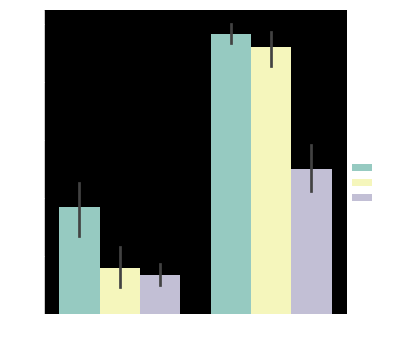

In [18]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=df)

In [19]:
df[['Ticket', 'Pclass', 'Embarked', 'Sex', 'Name']].sample(20)

,Ticket,Pclass,Embarked,Sex,Name
890,370376,3,Q,male,"Dooley, Mr. Patrick"
498,113781,1,S,female,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)"
664,STON/O 2. 3101285,3,S,male,"Lindqvist, Mr. Eino William"
261,347077,3,S,male,"Asplund, Master. Edvin Rojj Felix"
716,PC 17757,1,C,female,"Endres, Miss. Caroline Louise"
48,2662,3,C,male,"Samaan, Mr. Youssef"
392,3101277,3,S,male,"Gustafsson, Mr. Johan Birger"
361,SC/PARIS 2167,2,C,male,"del Carlo, Mr. Sebastiano"
495,2627,3,C,male,"Yousseff, Mr. Gerious"
142,STON/O2. 3101279,3,S,female,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ..."


Let's extract the titles of passenger names and see if this can tell us anything else about survival rate.

In [20]:
df['Name'].sample(20)

670    Brown, Mrs. Thomas William Solomon (Elizabeth ...
500                                     Calic, Mr. Petar
476                              Renouf, Mr. Peter Henry
187        Romaine, Mr. Charles Hallace ("Mr C Rolmane")
144                           Andrew, Mr. Edgardo Samuel
394    Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...
355                          Vanden Steen, Mr. Leo Peter
786                            Sjoblom, Miss. Anna Sofia
137                          Futrelle, Mr. Jacques Heath
649                      Stanley, Miss. Amy Zillah Elsie
341                       Fortune, Miss. Alice Elizabeth
6                                McCarthy, Mr. Timothy J
492                           Molson, Mr. Harry Markland
315                      Nilsson, Miss. Helmina Josefina
226                            Mellors, Mr. William John
620                                  Yasbeck, Mr. Antoni
720                    Harper, Miss. Annie Jessie "Nina"
127                            

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Don               1
Jonkheer          1
Mme               1
Capt              1
Sir               1
the Countess      1
Lady              1
Ms                1
Name: Title, dtype: int64

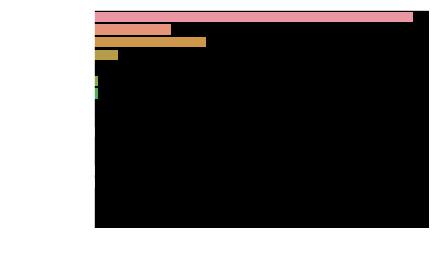

In [21]:
df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
sns.countplot(y='Title', data=df, orient='h')
df['Title'].value_counts()

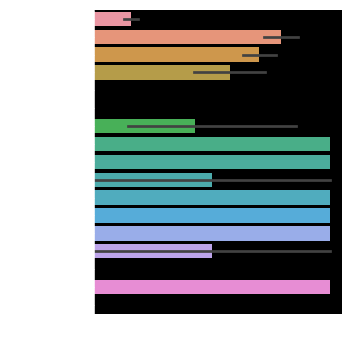

In [22]:
sns.catplot(
    x='Survived', 
    y='Title', 
    kind='bar', 
    data=df, 
    orient='h'
)

If anything, this plot confirms that women generally had a much higher survival rate than male passengers.

Let's examine the numeric variables.

In [23]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [24]:
# Create list for numeric fields
numeric_fields = ['Age', 'Fare', 'Parch', 'SibSp']

# Loop through each numeric field and test for normality
for num_field in numeric_fields:
    # Shapiro-Wilk test for Normality
    stat, p = shapiro(df[num_field])
    print("Test for Normality: %s" % num_field)
    print("Test statistic: %.3f;\tp-value: %.3f" % (stat, p))
    alpha = 0.05
    if p > alpha:
        print("*Sample looks Gaussian (fail to reject H0)\n")
    else:
        print("Sample does not look Gaussian (reject H0)\n")

    # Shapiro-Wilk test for Log-Normality
    stat, p = shapiro(np.log(df[num_field]))
    print("Test for Log-Normality: %s" % num_field)
    print("Test statistic: %.3f;\tp-value: %.3f" % (stat, p))
    alpha = 0.05
    if p <= alpha or stat == np.nan:
        print("*Sample looks Gaussian (fail to reject H0)\n\n")
    else:
        print("Sample does not look Gaussian (reject H0)\n\n")

Test for Normality: Age
Test statistic: 0.954;	p-value: 0.000
Sample does not look Gaussian (reject H0)

Test for Log-Normality: Age
Test statistic: 0.733;	p-value: 0.000
*Sample looks Gaussian (fail to reject H0)


Test for Normality: Fare
Test statistic: 0.522;	p-value: 0.000
Sample does not look Gaussian (reject H0)

Test for Log-Normality: Fare
Test statistic: nan;	p-value: 1.000
Sample does not look Gaussian (reject H0)


Test for Normality: Parch
Test statistic: 0.533;	p-value: 0.000
Sample does not look Gaussian (reject H0)

Test for Log-Normality: Parch
Test statistic: nan;	p-value: 1.000
Sample does not look Gaussian (reject H0)


Test for Normality: SibSp
Test statistic: 0.513;	p-value: 0.000
Sample does not look Gaussian (reject H0)

Test for Log-Normality: SibSp
Test statistic: nan;	p-value: 1.000
Sample does not look Gaussian (reject H0)


C:\Users\barte\venv\DataScienceProject\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
 

Our numeric features are neither normal or log-normal.

Therefore, we need to implement a non-parametric model.

# Multicollinearity
 * Can reduce overall cofficient(s), p-value (significance value), and unpredictable variance
    * Unpredictable variance
      * Overfitting - scoring well on the train set, but poorly on the test set
      * Lower statistical significance
          * Makes it difficult to ascertain the importance of a feature to the target
          * Fail to reject null hypothesis
          * Type II error for hypothesis testing - incorrectly retaining null hypothesis


## How do we combat multicollinearity?
### Principal Component Analysis (PCA)
PCA is still one of the best solutions to reduce the affect of multicollinearity in your dataset.
### Variable Inflaction Factor (VIF)
Alternatively, you can look at the coefficient score: 

>If you can identify which variables are affected by multicollinearity and the strength of the correlation, you're well on your way to determining whether you need to fix it. Fortunately, there is a very simple test to asses multicollinearity in your regression model. The variance inflaction factor (VIF) identifies correlation between independent variables and the strength of that correlation.

 * Determines if two features are collinear with each other
    * If VIF = 1:
        * They are NOT collinear
    * If VIF > 5:
        * The features should be REDUCED to ONE using PCA

### Analysis of Variance (ANOVA)
 * The higher the variance between variables:
    * Less likely they are related (correlated)

https://towardsdatascience.com/multicollinearity-in-data-science-c5f6c0fe6edf

Run PCA on numeric variables and analyze results by:
 * Analyze WITH scaling (covariance)
    * Plotting rotation matrix
    * Summarizing covariance matrix
        * Look at proportion of variance and cumulative proportion
        * We should be able to identify which features are "most important"
 * Analyze WITH scaling (correlation)
    * Plotting rotation matrix
    * Summarizing correlation matrix
        * Look at proportion of variance and cumulative proportion
        * This may or may not align with previous analysis

The differences in results from each analysis should emphasis that each uncovers different
conclusions, relationships, and structures. Selection of features using one or the other of
either analysis above can drastically change the outcome.



https://towardsdatascience.com/let-us-understand-the-correlation-matrix-and-covariance-matrix-d42e6b643c22

In [25]:
# Declare our numeric features in a list
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Instantiate and fit PCA object
pca = PCA()
pca.fit(df[numeric_features])

# Review results of PC analysis
total_variance = 0
for i, evr in enumerate(pca.explained_variance_ratio_):
    total_variance += evr*100
    print("PC%d: %.3f%%" % (i+1, evr*100))
    print("\tTotal explained variance: %.3f%%" % total_variance)

PC1: 93.560%
	Total explained variance: 93.560%
PC2: 6.359%
	Total explained variance: 99.919%
PC3: 0.048%
	Total explained variance: 99.967%
PC4: 0.018%
	Total explained variance: 99.984%
PC5: 0.016%
	Total explained variance: 100.000%


The first 2 components of our numeric features show that they attribute to a little over 99.9% of the variance in these features.

Next, we need to examine which of these features demonstrate multicollinearity.

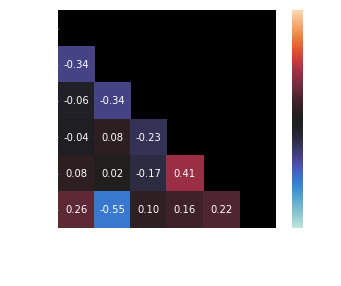

In [26]:
# Generate a coefficient matrix (ignoring passenger ID)
corr = df.drop('PassengerId', axis=1).corr()

# Mask out the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix on a heatmap
sns.heatmap(
    corr, 
    mask=mask, 
    vmax=1., 
    center=0,
    vmin=-1., 
    square=True, 
    annot=True,
    fmt='.2f'
)

Despite 'Pclass' and 'Fare' are more than 50% negatively correlated, it's still low enough to be just about as accurate as a coin flip. Therefore, we won't remove any of our features.

How do each of our features correlate with our target?

In [27]:
# Loop over each column in our DataFrame and calculate correlation on the target.
for col in df.drop(['PassengerId', 'Name', 'Ticket',], axis=1).columns.tolist():
    if df[col].dtype != 'float64' and col != 'Survived':
        print('Survival Correlation by:\t%s' % col)
        print(df[[col, 'Survived']].groupby(col, as_index=False).mean())
        print('-' * 48)

Survival Correlation by:	Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
------------------------------------------------
Survival Correlation by:	Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
------------------------------------------------
Survival Correlation by:	SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
------------------------------------------------
Survival Correlation by:	Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
------------------------------------------------
Survival Correlation by:	Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
------------------------------------------------
Survival Correlation by:	Title
           Title  Survived
0           

fLet's start throwing some models at the wall and see what sticks.

In [28]:
# Create list of each model we want to test
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
]

In [29]:
# Create pipeline object to store all transformers and estimators
numeric_transformer = Pipeline(
    [
        ('numimpute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    [
        ('catimpute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('categorical_transformer', categorical_transformer, ['Embarked', 'Sex', 'Title'])
    ]
)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('estimator', ensemble.AdaBoostClassifier())
    ]
)

In [30]:
# Create parameter grid to search
param_grid = {
    'estimator': MLA
}

# Create grid search object
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=RepeatedKFold(
        n_splits=5,
        n_repeats=5
    ),
    return_train_score=True
)

In [31]:
# Split dataset into train and test sets
X = df[numeric_features + ['Embarked', 'Sex', 'Title']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
# Fit grid on train set
grid.fit(X_train, y_train)

DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\barte\venv\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:720: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
C:\Users\barte\venv\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\barte\venv\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\barte\venv\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\barte\venv\DataScienceProject\lib\site-packages\sklearn\discriminant_anal

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x00000229ED3A1DD8>,
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numeric_transformer',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('numimpute',
                                                                                          Simp...
                                                     cols

In [33]:
df_results = pd.DataFrame(grid.cv_results_)
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,0.112475,0.008863,0.016116,0.001585,"(DecisionTreeClassifier(class_weight=None, cri...",{'estimator': (DecisionTreeClassifier(class_we...,0.791045,0.835821,0.791045,0.827068,...,0.840824,0.848598,0.848598,0.855805,0.848315,0.837079,0.852336,0.850467,0.846333,0.006642
1,0.041681,0.002396,0.008049,0.001336,"(DecisionTreeClassifier(class_weight=None, cri...",{'estimator': (DecisionTreeClassifier(class_we...,0.791045,0.798507,0.791045,0.849624,...,0.962547,0.964486,0.971963,0.964419,0.964419,0.979401,0.973832,0.968224,0.968337,0.005922
2,0.033839,0.005615,0.007878,0.001265,"(ExtraTreeClassifier(class_weight=None, criter...",{'estimator': (ExtraTreeClassifier(class_weigh...,0.761194,0.798507,0.768657,0.887218,...,0.985019,0.986916,0.986916,0.986891,0.985019,0.986891,0.988785,0.985047,0.986377,0.002217
3,0.128124,0.011401,0.006559,0.000699,([DecisionTreeRegressor(criterion='friedman_ms...,{'estimator': ([DecisionTreeRegressor(criterio...,0.828358,0.813433,0.783582,0.879699,...,0.898876,0.910280,0.900935,0.904494,0.902622,0.911985,0.917757,0.914019,0.909057,0.007504
4,0.037527,0.007972,0.007790,0.001301,"(DecisionTreeClassifier(class_weight=None, cri...",{'estimator': (DecisionTreeClassifier(class_we...,0.776119,0.835821,0.783582,0.909774,...,0.968165,0.970093,0.968224,0.970037,0.968165,0.970037,0.981308,0.973832,0.970659,0.005812


In [34]:
estimator_names = [p.__class__.__name__ for p in df_results['param_estimator']]
df_results['estimator_name'] = estimator_names
df_results[['estimator_name', 'mean_test_score', 'mean_train_score']]

,estimator_name,mean_test_score,mean_train_score
0,AdaBoostClassifier,0.812275,0.846333
1,BaggingClassifier,0.799102,0.968337
2,ExtraTreesClassifier,0.782934,0.986377
3,GradientBoostingClassifier,0.817365,0.909057
4,RandomForestClassifier,0.791317,0.970659
5,GaussianProcessClassifier,0.812575,0.870510
6,LogisticRegressionCV,0.821856,0.836827
7,PassiveAggressiveClassifier,0.741916,0.745465
8,RidgeClassifierCV,0.814671,0.828740
9,SGDClassifier,0.777246,0.786908


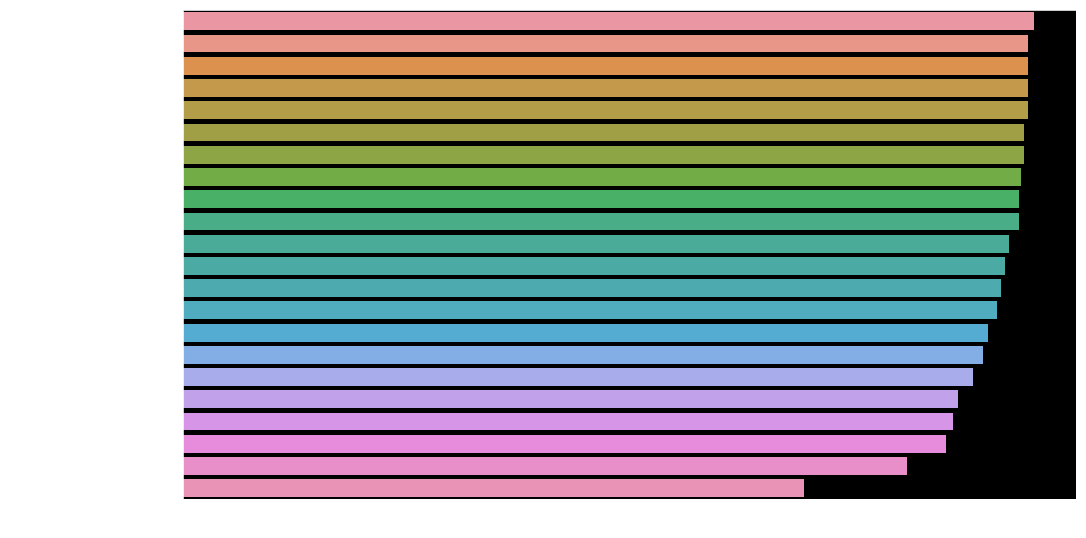

In [35]:
plt.figure(figsize=(16, 9))

sns.barplot(
    x='mean_test_score',
    y='estimator_name',
    data=df_results.sort_values(
        by='mean_test_score',
        ascending=False
    ),
)

Looks like SVC was the most accurate classifier, out of the box. Let's see if we can tune it to be more accurate.